# 📘 Interactive Simulation: The Law of Medium Numbers

This interactive widget lets us explore Taleb’s idea of **pre-asymptotics** — the observation that averages may converge *very differently* depending on the underlying distribution.

We compare the behavior of **sample means** across:

- **Normal(0,1)** — thin-tailed, well-behaved  
- **Student-t (df = 3)** — moderately fat-tailed  
- **Cauchy** — extremely fat-tailed, no mean  

---

## 🎯 What the widget does

For each distribution:

1. We draw **n_samples** values.  
2. We repeat this **n_experiments** times.  
3. We compute the **sample mean** for each experiment.  
4. We plot the histograms of sample means side by side.

This lets you *see*:

- how quickly the mean stabilizes for the Normal  
- how slowly (and noisily) it stabilizes for Student-t  
- how the mean of the Cauchy **refuses to converge**  
  (many values fly to extreme ranges)

---

## 🔍 Why this matters

This simulation reveals the core intuition behind the *Law of Medium Numbers*:

> In thin-tailed worlds, averages behave nicely.  
> In fat-tailed worlds, even huge sample sizes don’t guarantee stability.

This is why using averages to understand **wealth**, **social media virality**, **financial returns**, or **extreme events** can be dangerously misleading.

---

## 🕹 How to use the widget

- Increase **n_samples** to see how the mean stabilizes (or not).  
- Increase **n_experiments** to reveal the full distribution of sample means.  
- Watch how the Cauchy mean explodes even at 5,000 samples.

---



👉 So Taleb is warning: don’t rely on asymptotic Gaussian comfort. For many real-world fat-tailed phenomena, the world of “medium numbers” (pre-asymptotics) is where all the action — and risk — really is.

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# for reproducibility
rng = np.random.default_rng(42)


## 1. Helper function: running sample mean

Given a function that can draw samples from a distribution, we’ll compute the running mean:

$\bar{X}_n = \frac{1}{n} \sum_{i=1}^n X_i$


and see how it evolves as n grows.


In [3]:
def running_mean(sample_generator, n_samples: int) -> np.ndarray:
    """
    sample_generator: function(n) -> array of n samples
    n_samples: total number of samples to draw
    
    Returns:
        running_means: array of length n_samples
    """
    samples = sample_generator(n_samples)
    cumulative_sum = np.cumsum(samples)
    running_means = cumulative_sum / np.arange(1, n_samples + 1)
    return running_means


## 2. Define distributions

We'll compare three distributions:

- **Gaussian**: well-behaved, fast convergence of the mean.
- **Student-t (df = 3)**: fat tails, slower convergence.
- **Cauchy**: extremely fat tails, no true mean. Sample mean may never stabilize.


In [29]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, IntSlider

# RNG for reproducibility
rng = np.random.default_rng(42)

# --- Distributions ---

def sample_normal(size):
    return rng.normal(loc=0.0, scale=1.0, size=size)

def sample_student_t(size, df=3):
    return rng.standard_t(df=df, size=size)

def sample_cauchy(size):
    # Cauchy is t-distribution with df = 1
    return rng.standard_t(df=1, size=size)



## 3. Distributions: how do the tails look?

Let's plot histograms of the three distributions on the same range.

Interpretation idea:
- Think of them as toy models for different kinds of social phenomena:
  - Normal: human height, exam noise.
  - Student-t: returns of an asset with occasional big moves.
  - Cauchy: extreme "winner-takes-all" worlds (massive outliers).

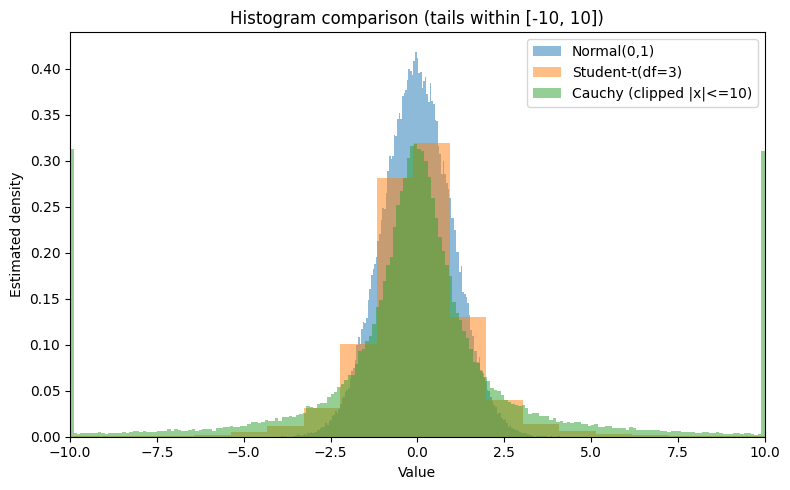

In [30]:
n_samples_hist = 100_000

data_normal = sample_normal(n_samples_hist)
data_t3 = sample_student_t(n_samples_hist, df=3)
data_cauchy = sample_cauchy(n_samples_hist)

# To keep histograms comparable, clip extreme Cauchy values to a range
clip_min, clip_max = -10, 10
data_cauchy_clipped = np.clip(data_cauchy, clip_min, clip_max)

fig, ax = plt.subplots(figsize=(8, 5))

bins = 200
ax.hist(data_normal, bins=bins, density=True, alpha=0.5, label="Normal(0,1)")
ax.hist(data_t3, bins=bins, density=True, alpha=0.5, label="Student-t(df=3)")
ax.hist(data_cauchy_clipped, bins=bins, density=True, alpha=0.5, label="Cauchy (clipped |x|<=10)")

ax.set_xlim(-10, 10)
ax.set_xlabel("Value")
ax.set_ylabel("Estimated density")
ax.set_title("Histogram comparison (tails within [-10, 10])")
ax.legend()

plt.tight_layout()
plt.show()

In [31]:
# --- Interactive plotting function ---

def plot_sample_means(n_samples=100, n_experiments=50):
    # --- Generate sample means for each distribution ---
    data_normal = sample_normal((n_experiments, n_samples))
    means_normal = data_normal.mean(axis=1)

    data_t3 = sample_student_t((n_experiments, n_samples), df=3)
    means_t3 = data_t3.mean(axis=1)

    data_cauchy = sample_cauchy((n_experiments, n_samples))
    means_cauchy = data_cauchy.mean(axis=1)

    # --- Plot ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
    bins = 30

    # NORMAL
    axes[0].hist(means_normal, bins=bins, density=True)
    axes[0].axvline(0, linestyle="--")
    axes[0].set_title("Normal(0,1) means")
    axes[0].set_xlabel("Mean value")

    # STUDENT-T
    axes[1].hist(means_t3, bins=bins, density=True)
    axes[1].axvline(0, linestyle="--")
    axes[1].set_title("Student-t(df=3) means")
    axes[1].set_xlabel("Mean value")

    # CAUCHY — dynamic scaling
    # Determine percentile-based plotting window (e.g. 1st–99th percentile)
    low, high = np.percentile(means_cauchy, [1, 99])

    axes[2].hist(means_cauchy, bins=bins, density=True)
    axes[2].axvline(0, linestyle="--")
    axes[2].set_xlim(low, high)
    axes[2].set_title(f"Cauchy means\n(1–99% range: {low:.2f} to {high:.2f})")
    axes[2].set_xlabel("Mean value")

    # Text about outliers
    outliers = np.sum((means_cauchy < low) | (means_cauchy > high))
    axes[2].text(
        0.05, 0.95,
        f"Outliers outside range: {outliers}/{n_experiments}",
        transform=axes[2].transAxes,
        fontsize=10,
        verticalalignment="top"
    )

    fig.suptitle(f"Distribution of Sample Means\nn_samples={n_samples}, n_experiments={n_experiments}",
                 fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()


# --- Widgets ---

interact(
    plot_sample_means,
    n_samples=IntSlider(value=100, min=5, max=5000, step=5, description="n_samples"),
    n_experiments=IntSlider(value=50, min=10, max=500, step=10, description="experiments"),
);

interactive(children=(IntSlider(value=100, description='n_samples', max=5000, min=5, step=5), IntSlider(value=…

## 3. Running mean comparison

We compute and plot the running mean for each distribution:

- If the Law of Large Numbers behaves nicely → the curve should settle.
- If not → the curve will keep jumping around.


In [32]:
n_samples = 100_000

rm_normal = running_mean(sample_normal, n_samples)
rm_t3 = running_mean(lambda n: sample_student_t(n, df=3), n_samples)
rm_cauchy = running_mean(sample_cauchy, n_samples)


## 4. Visualizing running means

We expect:
- **Normal**: running mean quickly hovers around 0.
- **Student-t (df = 3)**: more jumps, slower stabilization.
- **Cauchy**: wild jumps, no real stabilization even with many samples.


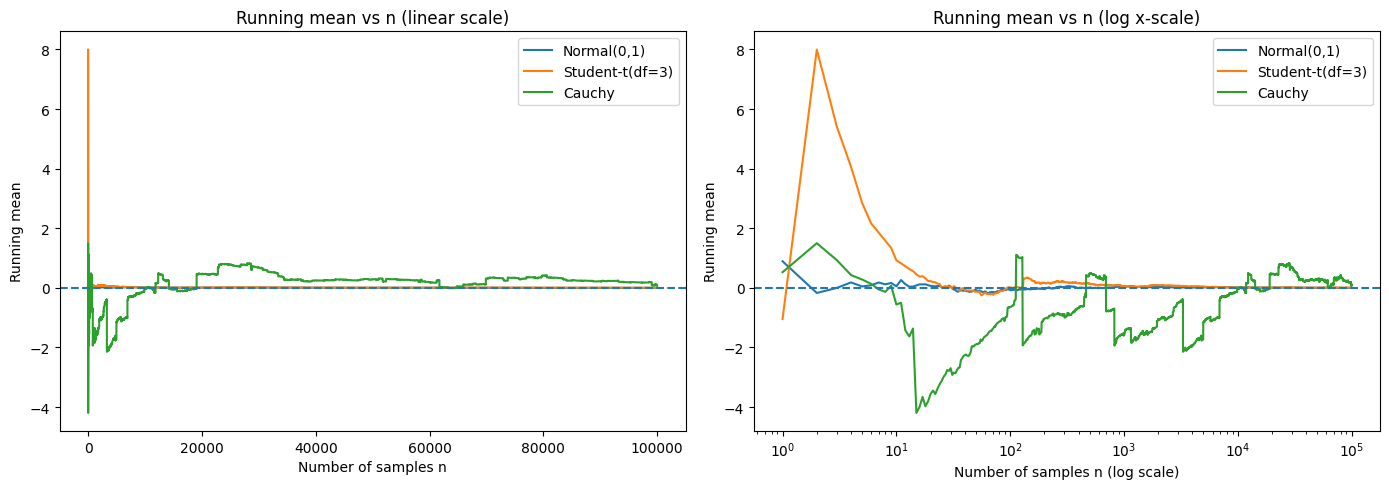

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(1, n_samples + 1)

# Left: linear scale
axes[0].plot(x, rm_normal, label="Normal(0,1)")
axes[0].plot(x, rm_t3, label="Student-t(df=3)")
axes[0].plot(x, rm_cauchy, label="Cauchy")
axes[0].axhline(0, linestyle="--")
axes[0].set_xlabel("Number of samples n")
axes[0].set_ylabel("Running mean")
axes[0].set_title("Running mean vs n (linear scale)")
axes[0].legend()

# Right: log x-scale
axes[1].plot(x, rm_normal, label="Normal(0,1)")
axes[1].plot(x, rm_t3, label="Student-t(df=3)")
axes[1].plot(x, rm_cauchy, label="Cauchy")
axes[1].axhline(0, linestyle="--")
axes[1].set_xscale("log")
axes[1].set_xlabel("Number of samples n (log scale)")
axes[1].set_ylabel("Running mean")
axes[1].set_title("Running mean vs n (log x-scale)")
axes[1].legend()

plt.tight_layout()
plt.show()


## 6. Interpreting this in a social science context

Think of each distribution as a simplified model for a real-world phenomenon:

- **Normal(0,1)**:
  - Like measurement noise, small test-score fluctuations, or height.
  - The average of a small sample is already pretty representative.

- **Student-t(df=3)**:
  - Like daily returns of a risky asset, or number of retweets per tweet.
  - Most values are moderate, but occasionally big spikes happen.
  - The average is more fragile and needs more data to stabilize.

- **Cauchy**:
  - Cartoon model for extreme "winner-takes-all" phenomena:
    - wealth in a world with ultra-billionaires,
    - viral content where 1 post dominates attention.
  - The sample mean never really settles. Your estimate of "typical" can be destroyed by a single observation.

This illustrates Taleb's point: in **fat-tailed worlds**, the "Law of Large Numbers" is not your friend at realistic sample sizes. We live in the land of **medium numbers**, where rare events dominate aggregates.

